In [66]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid


from sklearn.model_selection import train_test_split

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print("Device:", device)

# User configurable: Set to True for RGB input (3 channels), False for Grayscale (1 channel)
use_rgb_input = True

Device: mps


In [68]:
np.random.seed(0)
torch.manual_seed(0)

# Data

In [69]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types")

print("Path to dataset files:", path)

Path to dataset files: /Users/sayansuos/.cache/kagglehub/datasets/vishalsubbiah/pokemon-images-and-types/versions/4


In [70]:
from PIL import Image
import os
from pathlib import Path
import kagglehub

# 1. Utiliser kagglehub pour avoir le chemin correct automatiquement
# (Cela évite les erreurs de version "v4" vs "v5")
base_path = Path(kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types"))
output_folder = Path("./data/pokemon_images_256")
output_folder.mkdir(parents=True, exist_ok=True)

size = (256, 256)
valid_exts = {".png", ".jpg", ".jpeg", ".webp"}
count = 0

# 2. On scanne TOUS les sous-dossiers pour être sûr de trouver les images
print(f"Recherche dans : {base_path}")

for img_path in base_path.rglob("*"):
    if img_path.suffix.lower() in valid_exts:
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(size, Image.LANCZOS)

            # 3. IMPORTANT : on met tout en minuscules pour correspondre au CSV
            out_name = img_path.stem.lower() + ".jpg"
            img.save(output_folder / out_name, "JPEG", quality=95)

            count += 1

        except Exception as e:
            print(f"Erreur avec {img_path}: {e}")

print(f"{count} images redimensionnées et sauvegardées dans {output_folder}")

Recherche dans : /Users/sayansuos/.cache/kagglehub/datasets/vishalsubbiah/pokemon-images-and-types/versions/4
809 images redimensionnées et sauvegardées dans data/pokemon_images_256


In [71]:
path = kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types")
csv_path = os.path.join(path, "pokemon.csv")

df = pd.read_csv(csv_path)
df.head()


,Name,Type1,Type2,Evolution
0,bulbasaur,Grass,Poison,ivysaur
1,ivysaur,Grass,Poison,venusaur
2,venusaur,Grass,Poison,NaN
3,charmander,Fire,NaN,charmeleon
4,charmeleon,Fire,NaN,charizard


In [72]:
training_df, validation_df = train_test_split(
    df,
    test_size=0.1,
    random_state=0,
    shuffle=True
)

In [73]:
class CustomDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform
        self.classes = sorted(self.data["Type1"].unique())

        if isinstance(self.data.iloc[0]["Type1"], str):
            classes = sorted(self.data["Type1"].unique())
            self.label_to_idx = {c: i for i, c in enumerate(classes)}
        else:
            self.label_to_idx = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        name = row["Name"]

        img_path = os.path.join(self.image_dir, name) + ".jpg"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        label = row["Type1"]
        if self.label_to_idx is not None:
            label = self.label_to_idx[label]

        return name, image, label


In [74]:
image_size = 128

training_data = CustomDataset(
    data=training_df,
    image_dir=output_folder,
    transform=transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
        ])
)
validation_data = CustomDataset(
    data=validation_df,
    image_dir=output_folder,
    transform=transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
        ])
)

In [75]:
print(f"Nombre de données d'entrainement : {len(training_data)}")
print(f"Nombre de classes : {len(training_data.label_to_idx)}")
print(f"Classes : {training_data.label_to_idx}")

Nombre de données d'entrainement : 728
Nombre de classes : 18
Classes : {'Bug': 0, 'Dark': 1, 'Dragon': 2, 'Electric': 3, 'Fairy': 4, 'Fighting': 5, 'Fire': 6, 'Flying': 7, 'Ghost': 8, 'Grass': 9, 'Ground': 10, 'Ice': 11, 'Normal': 12, 'Poison': 13, 'Psychic': 14, 'Rock': 15, 'Steel': 16, 'Water': 17}


In [76]:
loader = DataLoader(training_data, batch_size=128, shuffle=False)

sum_ = 0.0
sum_sq = 0.0
num_pixels = 0

for _, imgs, _ in loader:
    num_pixels += imgs.numel()
    sum_ += imgs.sum().item()
    sum_sq += (imgs ** 2).sum().item()

mean = sum_ / num_pixels
data_variance = sum_sq / num_pixels - mean ** 2


# VQVAE

In [77]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim   # Taille des embeddings
        self._num_embeddings = num_embeddings # Nombre d'embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim) # Dictionnaire qui contient tous les vecteurs
        self._embedding.weight.data.normal_() # On le remplit d'abord de v.a.
        self._commitment_cost = commitment_cost # Punit l'encodeur s'il s'éloigne trop d'une valeur existante

        # Ici, pcq on utilise par une GD, mais une EMA (moyenne mobile)
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings)) # Garde en mémoire cb de fois le vecteur a été choisi par le modèle
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim)) # Pour conserver les changements de poids sur les vecteurs
        self._ema_w.data.normal_()

        self._decay = decay # Force de la mémoire, souvent = 99% i.e. 1% de 'nouveauté' acceptée
        self._epsilon = epsilon  # Pour éviter de diviser par 0 si un vecteur n'est jamais choisi

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC = Batch Height Width Channel
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input: on écrase BHW en une colonne
        flat_input = inputs.view(-1, self._embedding_dim) # = 1 zone de l'image

        # Calculate distances: dist entre chaque vecteur de l'image et chaque vecteur du dict des embeddings
        # Matrice ligne = point de l'image et colonne = vecteur du dictionnaire. Plus le chiffre est petit, plus ils se ressemblent.
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # on choisit la plus petite distance
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device) # on créé le one-hot vector
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten: on multiplie les one=hots vectors par les vecteurs du dict, et on redonne la bonne forme
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0) # On compte combien de fois chaque vecteur du dictionnaire a été choisi dans ce batch

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n) # aucun où un vecteur n'est jamais choisi

            dw = torch.matmul(encodings.t(), flat_input) # somme de tous les vecteurs réels de l'image qui ont "choisi" le vecteur i du dictionnaire
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw) # maj du poids moyen en utilisant encore le decay
            # calcul des vrais poids du dic : Moyenne = Somme des valeurs / Nombre d'utilisations
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # difference entre le vecteur de l'encodeur et le vecteur du dict choisi
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach() # detach() utilisé lorsqu'on ne veut pas que ce soit pris en compte lors du BACKWARD?
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10))) # indicateur qui dit si le modèle utilise bien tout son dictionnaire

        # convert quantized from BHWC -> BCHW

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [78]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False), # regarde les pixels voisins
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False) # regarde qu'un pixel
        )

    def forward(self, x):
        return x + self._block(x) # on passe l'info originale et les transformations à la couche suivante (raccourci)

# Pile de couches qui ajoute ce qu'elle vient d'apprendre à l'image d'origine au lieu de la remplacer
class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [79]:
class Encoder(nn.Module): # Résumer les informations de l'image dans un vecteur
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        # Réduit la taille par 2, et encore par 2 (cf. stride)
        # Mais l'image devient de + en + épaisse (out_channels) -> remplace les couleurs par des caractéristiques
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2, # Réduction de la taille
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        # Stabiliser les informations (cf. stride)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens, # Affine les infos de l'image
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [80]:
class Decoder(nn.Module): # Reconstruire l'image à partir du résumé d'information
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_output_channels=3):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1) # Juste histoire d'apprendre ?

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens) # Pour capturer les détails sans perdre l'information globale

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1) # Augmente la taille x 2

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_output_channels,
                                                kernel_size=4,
                                                stride=2, padding=1) # Augmente la taille x 2

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

In [81]:
# A choisir selon la taille du données: 256 et 15000 un peu bcp pour les pokemons
batch_size = 32
num_training_updates = 15000

epochs = num_training_updates // (len(training_data) // batch_size)

num_hiddens = 128            # Puissance de calcul des convolutions
num_residual_hiddens = 32       # Pour le bloc résiduel
num_residual_layers = 2

embedding_dim = 64              # Taille des vecteurs dans le dictionnaire
num_embeddings = 128           # Nombre de vecteurs dans le dictionnaire -> à ajuster avec la perplexité

commitment_cost = 0.5      # Force l'encodeur à ne pas trop s'éloigner du dictionnaire -> mettre à 0.5 si le modèle converge pas

decay = 0.95

learning_rate = 1e-4

print("Iteration per epoch:", len(training_data) // batch_size)
print("Epoch:", epochs)

Iteration per epoch: 22
Epoch: 681


In [82]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay, num_input_channels=3, num_output_channels=3):
        super(Model, self).__init__()

        # Résumé compact de l'image
        self._encoder = Encoder(num_input_channels, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        # Adapter la taille entre l'encoder et le VQVAE
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        # Remplace le résumé par des vecteurs "propres" du dictionnaire
        self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                           commitment_cost, decay)
        # Image reconstruite
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens, num_output_channels=num_output_channels)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [83]:
num_input_channels = 3 if use_rgb_input else 1
num_output_channels = 3 if use_rgb_input else 1

model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay,
              num_input_channels=num_input_channels,
              num_output_channels=num_output_channels).to(device)

In [84]:
checkpoint = torch.load("checkpoints/vqvae_pokemon_best.pth", map_location=device)
model.to(device).load_state_dict(checkpoint)

<All keys matched successfully>

In [85]:
# row_settings=["depth", "var_names"] permet de voir le nom de tes variables
summary(model, input_size=(batch_size, 3, image_size, image_size), row_settings=["depth", "var_names"])

Layer (type (var_name):depth-idx)                  Output Shape              Param #
Model (Model)                                      --                        --
├─Encoder (_encoder): 1-1                          [32, 128, 32, 32]         --
│    └─Conv2d (_conv_1): 2-1                       [32, 64, 64, 64]          3,136
│    └─Conv2d (_conv_2): 2-2                       [32, 128, 32, 32]         131,200
│    └─Conv2d (_conv_3): 2-3                       [32, 128, 32, 32]         147,584
│    └─ResidualStack (_residual_stack): 2-4        [32, 128, 32, 32]         --
│    │    └─ModuleList (_layers): 3-1              --                        81,920
├─Conv2d (_pre_vq_conv): 1-2                       [32, 64, 32, 32]          8,256
├─VectorQuantizerEMA (_vq_vae): 1-3                --                        16,384
├─Decoder (_decoder): 1-4                          [32, 3, 128, 128]         --
│    └─Conv2d (_conv_1): 2-5                       [32, 128, 32, 32]         73,856
│    └─

# MaskGIT

In [86]:
training_loader = DataLoader(training_data,
                               batch_size=4, # Reduced batch size to manage memory
                               shuffle=True,
                               pin_memory=True)

validation_loader = DataLoader(validation_data,
                               batch_size=4, # Reduced batch size to manage memory
                               shuffle=True,
                               pin_memory=True)

In [87]:
_, img, label = training_data[0]
img.shape
H, W = img.shape[-2:]
print("Image size:", H, 'x', W)

codebook_size = model._vq_vae._embedding.weight.shape[0]
print("Codebook size:", codebook_size)

num_classes = len(training_data.classes)
print("Number of classes:", num_classes)

model.to(device)
with torch.no_grad():
    img = img.to(device)
    tokens = model._encoder(img)
num_tokens = tokens.shape[1] * tokens.shape[2]
print("Number of tokens:", num_tokens)

Image size: 128 x 128
Codebook size: 128
Number of classes: 18
Number of tokens: 1024


In [88]:
import math
import torch
import torch.nn as nn

def weights_init(m):
    classname = m.__class__.__name__
    if "Linear" in classname or "Embedding" == classname:
        print(f"Initializing Module {classname}.") # On initialise les poids aléatoirement (loi normale) qu'on tronque si c'est + de 2x l'ecart-type
        nn.init.trunc_normal_(m.weight.data, 0.0, 0.02) 
    elif "Parameter" in classname:
        return nn.init.trunc_normal_(m, 0.0, 0.02)


class Attention(nn.Module):
    """
    Simple Self-Attention algorithm. Potential for optimization using a non-quadratic attention mechanism in complexity.
    -> Linformer, Reformer etc.
    """
    def __init__(self, dim=768, heads=8):
        super(Attention, self).__init__()
        d = dim // heads
        self.q, self.k, self.v = nn.Linear(dim, d), nn.Linear(dim, d), nn.Linear(dim, d)
        self.norm = d ** 0.5
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        q, k, v = self.q(x), self.k(x), self.v(x)
        qk = torch.softmax(q @ k.transpose(-2, -1) / self.norm, dim=-1)
        qk = self.dropout(qk)
        attn = torch.matmul(qk, v)
        return attn


class MultiHeadAttention(nn.Module):
    """
    Implementation of MultiHeadAttention, splitting it up to multiple Self-Attention layers and concatenating
    the results and subsequently running it through one linear layer of same dimension.
    """
    def __init__(self, dim=768, heads=8):
        super(MultiHeadAttention, self).__init__()
        self.self_attention_heads = nn.ModuleList([Attention(dim, heads) for _ in range(heads)])
        self.projector = nn.Linear(dim, dim)

    def forward(self, x):
        out = torch.cat([sa_head(x) for sa_head in self.self_attention_heads], dim=-1)
        out = self.projector(out)
        return out


class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class Encoder(nn.Module):
    """
    Transformer encoder using MultiHeadAttention and MLP along with skip connections and LayerNorm
    """
    def __init__(self, dim=768, hidden_dim=3072):
        super(Encoder, self).__init__()
        # self.MultiHeadAttention = MultiHeadAttention(dim)
        self.MultiHeadAttention = nn.MultiheadAttention(dim, num_heads=8, batch_first=True, dropout=0.1)
        self.LayerNorm1 = nn.LayerNorm(dim, eps=1e-12)
        self.LayerNorm2 = nn.LayerNorm(dim, eps=1e-12)
        self.MLP = nn.Sequential(*[
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p=0.1)
        ])
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        # attn = self.MultiHeadAttention(x)
        attn, _ = self.MultiHeadAttention(x, x, x, need_weights=False)
        attn = self.dropout(attn)
        x = x.add(attn)
        x = self.LayerNorm1(x)
        mlp = self.MLP(x)
        x = x.add(mlp)
        x = self.LayerNorm2(x)
        return x


class BidirectionalTransformer(nn.Module):
    def __init__(self, args):
        super(BidirectionalTransformer, self).__init__()
        self.num_image_tokens = args.num_image_tokens
        self.tok_emb = nn.Embedding(args.num_codebook_vectors + 2, args.dim)
        # self.pos_emb = PositionalEmbedding(args.dim, self.num_image_tokens + 1)
        self.pos_emb = nn.Parameter(torch.zeros(args.num_image_tokens + 1, args.dim))
        # self.register_buffer("pos_emb", nn.init.trunc_normal_(nn.Parameter(torch.zeros(1024, args.dim)), 0., 0.02))
        self.blocks = nn.Sequential(*[Encoder(args.dim, args.hidden_dim) for _ in range(args.n_layers)])
        self.Token_Prediction = nn.Sequential(*[
            nn.Linear(in_features=args.dim, out_features=args.dim),
            nn.GELU(),
            nn.LayerNorm(args.dim, eps=1e-12)
        ])
        self.bias = nn.Parameter(torch.zeros(args.num_codebook_vectors + 2))
        self.ln = nn.LayerNorm(args.dim, eps=1e-12)
        self.drop = nn.Dropout(p=0.1)
        self.apply(weights_init)

    def forward(self, x):
        token_embeddings = self.tok_emb(x)
        t = token_embeddings.shape[1]
        position_embeddings = self.pos_emb[:t, :]
        # position_embeddings = self.pos_emb(x)
        embed = self.drop(self.ln(token_embeddings + position_embeddings))
        embed = self.blocks(embed)
        embed = self.Token_Prediction(embed)
        logits = torch.matmul(embed, self.tok_emb.weight.T) + self.bias

        return logits

In [89]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math


class VQVAETransformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.num_image_tokens = args.num_image_tokens
        self.sos_token = args.num_codebook_vectors + 1
        self.mask_token_id = args.num_codebook_vectors
        self.choice_temperature = 4.5
        self._CONFIDENCE_OF_KNOWN_TOKENS = torch.Tensor([torch.inf]).to(device)

        self.gamma = self.gamma_func("cosine") 

        # self.transformer = BidirectionalTransformer(
        #                         patch_size=8, embed_dim=args.dim, depth=args.n_layers, num_heads=12, mlp_ratio=4, qkv_bias=True,
        #                         norm_layer=partial(nn.LayerNorm, eps=1e-6), vocab_size=8192+1)
        self.transformer = BidirectionalTransformer(args)
        self.vqvae = model.eval()
        print(f"Transformer parameters: {sum([p.numel() for p in self.transformer.parameters()])}")

    def load_checkpoint(self, epoch):
        self.load_state_dict(torch.load(os.path.join("checkpoints", f"transformer_pokemon_epoch_{epoch}.pt")))
        print("Check!")


    @torch.no_grad()
    def encode_to_z(self, x):
        # Pass through encoder
        z_e = self.vqvae._encoder(x)
        # Pass through pre-vq convolution
        z_pre_vq = self.vqvae._pre_vq_conv(z_e)
        # Pass through VQ-VAE module to get quantized latent and encodings
        # _vq_vae returns loss, quantized (tensor), perplexity, encodings (one-hot)
        _, quant_z, _, encodings = self.vqvae._vq_vae(z_pre_vq)
        # Convert one-hot encodings to discrete indices
        indices = torch.argmax(encodings, dim=1)
        indices = indices.view(quant_z.shape[0], -1)
        return quant_z, indices

    def forward(self, x):
        # _, z_indices = self.encode_to_z(x)
        #
        # r = np.random.uniform()
        # mask = torch.bernoulli(r * torch.ones(z_indices.shape[-1], device=z_indices.device))
        # mask = mask.round().bool()
        #
        # target = z_indices[:, mask]
        #
        # logits = self.transformer(z_indices, mask)

        _, z_indices = self.encode_to_z(x)
        sos_tokens = torch.ones(x.shape[0], 1, dtype=torch.long, device=z_indices.device) * self.sos_token

        r = math.floor(self.gamma(np.random.uniform()) * z_indices.shape[1])
        sample = torch.rand(z_indices.shape, device=z_indices.device).topk(r, dim=1).indices
        mask = torch.zeros(z_indices.shape, dtype=torch.bool, device=z_indices.device)
        mask.scatter_(dim=1, index=sample, value=True)

        # torch.rand(z_indices.shape, device=z_indices.device)
        # mask = torch.bernoulli(r * torch.ones(z_indices.shape, device=z_indices.device))
        # mask = torch.bernoulli(torch.rand(z_indices.shape, device=z_indices.device))
        # mask = mask.round().to(dtype=torch.int64)
        # masked_indices = torch.zeros_like(z_indices)
        masked_indices = self.mask_token_id * torch.ones_like(z_indices, device=z_indices.device)
        a_indices = mask * z_indices + (~mask) * masked_indices

        a_indices = torch.cat((sos_tokens, a_indices), dim=1)

        target = torch.cat((sos_tokens, z_indices), dim=1)

        logits = self.transformer(a_indices)

        return logits, target

    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        if k == 0:
            out[:, :] = self.sos_token
        else:
            out[out < v[..., [-1]]] = self.sos_token
        return out

    def gamma_func(self, mode="cosine"): # Fonction de scheduling
        if mode == "linear":
            return lambda r: 1 - r
        elif mode == "cosine":
            return lambda r: np.cos(r * np.pi / 2)
        elif mode == "square":
            return lambda r: 1 - r ** 2
        elif mode == "cubic":
            return lambda r: 1 - r ** 3
        else:
            raise NotImplementedError

    def create_input_tokens_normal(self, num, label=None):
        # label_tokens = label * torch.ones([num, 1])
        # Shift the label by codebook_size
        # label_tokens = label_tokens + self.vqgan.codebook.num_codebook_vectors
        # Create blank masked tokens
        blank_tokens = torch.ones((num, self.num_image_tokens), device=device)
        masked_tokens = self.mask_token_id * blank_tokens
        # Concatenate the two as input_tokens
        # input_tokens = torch.concat([label_tokens, masked_tokens], dim=-1)
        # return input_tokens.to(torch.int32)
        return masked_tokens.to(torch.int64)

    def tokens_to_logits(self, seq):
        logits = self.transformer(seq)
        # logits = logits[..., :self.vqgan.codebook.num_codebook_vectors]  # why is maskgit returning [8, 257, 2025]?
        return logits

    def mask_by_random_topk(self, mask_len, probs, temperature=1.0):
        confidence = torch.log(probs) + temperature * torch.distributions.gumbel.Gumbel(0, 1).sample(probs.shape).to(device)
        sorted_confidence, _ = torch.sort(confidence, dim=-1)
        # Obtains cut off threshold given the mask lengths.
        cut_off = torch.take_along_dim(sorted_confidence, mask_len.to(torch.long), dim=-1)
        # Masks tokens with lower confidence.
        masking = (confidence < cut_off)
        return masking

    def sample_good(self, inputs=None, num=1, T=11, mode="cosine", masked_ratio=0):
        # self.transformer.eval()
        N = self.num_image_tokens
        if inputs is None:
            inputs = self.create_input_tokens_normal(num) # Grille remplis de masked tokens
        else:
            H, W = inputs.shape

            inputs = inputs.clone()

            mask = torch.rand(H, W, device=inputs.device) < masked_ratio
            inputs[mask] = self.mask_token_id
            inputs.to(device)

        sos_tokens = torch.ones(inputs.shape[0], 1, dtype=torch.long, device=inputs.device) * self.sos_token
        inputs = torch.cat((sos_tokens, inputs), dim=1)

        unknown_number_in_the_beginning = torch.sum(inputs == self.mask_token_id, dim=-1)
        gamma = self.gamma_func(mode)
        cur_ids = inputs  # [8, 257]

        for t in range(T):
            logits = self.tokens_to_logits(cur_ids)  # call transformer to get predictions [8, 257, 1024]
            sampled_ids = torch.distributions.categorical.Categorical(logits=logits).sample()

            unknown_map = (cur_ids == self.mask_token_id)  # which tokens need to be sampled -> bool [8, 257]
            sampled_ids = torch.where(unknown_map, sampled_ids, cur_ids)  # replace all -1 with their samples and leave the others untouched [8, 257]

            ratio = 1. * (t + 1) / T  # just a percentage e.g. 1 / 12
            mask_ratio = gamma(ratio)

            probs = F.softmax(logits, dim=-1)  # convert logits into probs [8, 257, 1024]
            selected_probs = torch.squeeze(torch.take_along_dim(probs, torch.unsqueeze(sampled_ids, -1), -1), -1)  # get probability for selected tokens in categorical call, also for already sampled ones [8, 257]

            selected_probs = torch.where(unknown_map, selected_probs, self._CONFIDENCE_OF_KNOWN_TOKENS)  # ignore tokens which are already sampled [8, 257]

            mask_len = torch.unsqueeze(torch.floor(unknown_number_in_the_beginning * mask_ratio), 1)  # floor(256 * 0.99) = 254 --> [254, 254, 254, 254, ....]
            mask_len = torch.maximum(torch.zeros_like(mask_len), torch.minimum(torch.sum(unknown_map, dim=-1, keepdim=True)-1, mask_len))  # add -1 later when conditioning and also ones_like. Zeroes just because we have no cond token
            # max(1, min(how many unknown tokens, how many tokens we want to sample))

            # Adds noise for randomness
            masking = self.mask_by_random_topk(mask_len, selected_probs, temperature=self.choice_temperature * (1. - ratio))
            # Masks tokens with lower confidence.
            cur_ids = torch.where(masking, self.mask_token_id, sampled_ids)
            # print((cur_ids == 8192).count_nonzero())

        # self.transformer.train()
        return cur_ids[:, 1:]
    
    @torch.no_grad()
    def sample_goods_gibbs(self, num=1, T=None):
        N = self.num_image_tokens
        T = T if T is not None else N # 1 passe sur chake token
        
        inputs = self.create_input_tokens_normal(num) # Grille remplis de masked tokens
        sos_tokens = torch.ones(inputs.shape[0], 1, dtype=torch.long, device=device) * self.sos_token
        cur_ids = torch.cat((sos_tokens, inputs), dim=1)

        # Gibbs sampling
        for t in range(1, N + 1): # On parcourt les positions de 1 à 64
            logits = self.tokens_to_logits(cur_ids) # On récupère les logies
            probs = F.softmax(logits[:, t, :], dim=-1) # On regarde uniquement la probabilité à la position t
            sampled_id = torch.distributions.categorical.Categorical(probs=probs).sample() # On sample
            cur_ids[:, t] = sampled_id # On modifie le token

        return cur_ids[:, 1:]
    
    
    def get_log_prob(self, ids):
        logits = self.tokens_to_logits(ids) # [Batch, Séquence, Vocab_Size]
        
        # On récupère la log-probabilité de chaque token réellement présent dans 'ids'
        log_probs = torch.log_softmax(logits, dim=-1)
        
        # On extrait les log-probs des tokens choisis (en utilisant gather)
        # On décale souvent de 1 car le logit i prédit le token i+1
        target_log_probs = torch.gather(log_probs[:, :-1, :], 2, ids[:, 1:].unsqueeze(-1)).squeeze(-1)
        
        # On fait la somme sur toute la séquence pour avoir la probabilité de l'image
        return target_log_probs.sum(dim=1)
    
    @torch.no_grad()
    def sample_metropolis_hastings(self, num=1, steps=100, jump_size=5):
        # 1. Initialisation : On part d'une image aléatoire (ou totalement masquée)
        # Pour MH, il faut une séquence complète pour commencer
        inputs = self.create_input_tokens_normal(num) # Grille remplis de masked tokens
        sos_tokens = torch.ones(num, 1, dtype=torch.long, device=device) * self.sos_token
        cur_ids = torch.cat((sos_tokens, inputs), dim=1)

        for s in range(steps):
            # On choisit 'jump_size' positions au hasard à modifier
            mask_indices = torch.rand(cur_ids[:, 1:].shape, device=device).topk(jump_size, dim=1).indices + 1

            proposal_input = cur_ids.clone()
            for b in range(num): # Nouvelle image avec ces positions masquées
                proposal_input[b, mask_indices[b]] = self.mask_token_id
                
            logits = self.tokens_to_logits(proposal_input) # On crée les samples associés
            proposal_ids = torch.distributions.categorical.Categorical(logits=logits).sample()
            
            candidate_ids = cur_ids.clone() # Nouveay candidats
            for b in range(num):
                candidate_ids[b, mask_indices[b]] = proposal_ids[b, mask_indices[b]]

            # Dans l'idéal, on compare la probabilité jointe P(image).
            # Ici, on peut comparer les logits (la confiance du modèle)
            old_conf = self.get_log_prob(cur_ids) # On compare les logits
            new_conf = self.get_log_prob(candidate_ids)
            
            acceptance_prob = torch.exp(new_conf - old_conf) # Probabilité d'acceptation alpha = min(1, P(new)/P(old))
            accept = torch.rand(num, device=device) < acceptance_prob
            
            cur_ids[accept] = candidate_ids[accept] # On modifie les positions où c'est meilleur

        return cur_ids[:, 1:]

    @torch.no_grad()
    def log_images(self, x, mode="cosine"):
        log = dict()

        _, z_indices = self.encode_to_z(x)

        # create new sample
        index_sample = self.sample_good(mode=mode)
        x_new = self.indices_to_image(index_sample)

        # create a "half" sample
        z_start_indices = z_indices[:, :z_indices.shape[1] // 2]
        half_index_sample = self.sample_good(z_start_indices, mode=mode)
        x_sample = self.indices_to_image(half_index_sample)

        # create reconstruction
        x_rec = self.indices_to_image(z_indices)

        log["input"] = x
        log["rec"] = x_rec
        log["half_sample"] = x_sample
        log["new_sample"] = x_new
        return log, torch.concat((x, x_rec, x_sample, x_new))

    def indices_to_image(self, indices, p1=32, p2=32):
        # Reshape indices to match the VQ-VAE latent space dimensions
        # Assuming num_tokens = H * W where H=p1, W=p2
        # This line was incorrect and caused issues. The VQ-VAE's _decoder expects input with embedding_dim channels.
        # Instead, we need to convert indices back to embedding vectors.

        # Get embedding weights from the vqvae's VectorQuantizerEMA module
        embedding_weights = self.vqvae._vq_vae._embedding.weight

        # Map indices to embedding vectors
        # indices shape: [batch_size, num_tokens]
        # embedding_weights shape: [num_embeddings, embedding_dim]
        # Resulting shape: [batch_size, num_tokens, embedding_dim]
        ix_to_vectors = F.embedding(indices, embedding_weights)

        # Reshape to [batch_size, H, W, embedding_dim] or similar, then permute
        # For CIFAR-10, we had 32x32 images, and num_tokens was 64, which implies 8x8 latent space.
        # The encoder reduces spatial dimensions by a factor of 4 (4x4 = 16 times reduction in pixels).
        # So, 32x32 image becomes 8x8 latent grid. num_tokens = 8 * 8 = 64.
        # This means p1=8, p2=8 for the latent grid spatial dimensions.
        latent_h = int(np.sqrt(self.num_image_tokens))
        latent_w = int(np.sqrt(self.num_image_tokens))
        ix_to_vectors = ix_to_vectors.reshape(indices.shape[0], latent_h, latent_w, embedding_weights.shape[1])

        # Permute to BCHW format for the decoder
        ix_to_vectors = ix_to_vectors.permute(0, 3, 1, 2).contiguous()

        # Decode the image
        image = self.vqvae._decoder(ix_to_vectors)
        return image

    @staticmethod
    def create_masked_image(image: torch.Tensor, x_start: int = 100, y_start: int = 100, size: int = 50):
        mask = torch.ones_like(image, dtype=torch.int)
        mask[:, :, x_start:x_start + size, y_start:y_start + size] = 0
        return image * mask, mask
    
    def load_transformer_checkpoint(self, epoch, device=device):
      ckpt_path = os.path.join("checkpoints", f"transformer_pokemon_epoch_{epoch}.pt")
      ckpt = torch.load(ckpt_path, map_location=device)

      self.transformer.load_state_dict(ckpt["model"])
      self.transformer.eval()

      print(f"✅ Transformer chargé | epoch={ckpt['epoch']} | step={ckpt['step']}")

1e-06
5.05e-05
0.0001
9.897959183673469e-05
9.795918367346938e-05
9.693877551020407e-05
9.591836734693876e-05
9.489795918367344e-05
9.387755102040813e-05
9.285714285714282e-05
9.18367346938775e-05
9.08163265306122e-05
8.979591836734688e-05
8.877551020408157e-05
8.775510204081626e-05
8.673469387755094e-05
8.571428571428563e-05
8.469387755102032e-05
8.3673469387755e-05
8.26530612244897e-05
8.163265306122438e-05
8.061224489795907e-05
7.959183673469376e-05
7.857142857142844e-05
7.755102040816313e-05
7.653061224489782e-05
7.551020408163251e-05
7.44897959183672e-05
7.346938775510188e-05
7.244897959183657e-05
7.142857142857126e-05
7.040816326530595e-05
6.938775510204063e-05
6.836734693877532e-05
6.734693877551001e-05
6.63265306122447e-05
6.530612244897938e-05
6.428571428571407e-05
6.326530612244876e-05
6.224489795918345e-05
6.122448979591813e-05
6.020408163265283e-05
5.918367346938752e-05
5.816326530612222e-05
5.714285714285691e-05
5.6122448979591606e-05
5.51020408163263e-05
5.408163265306099

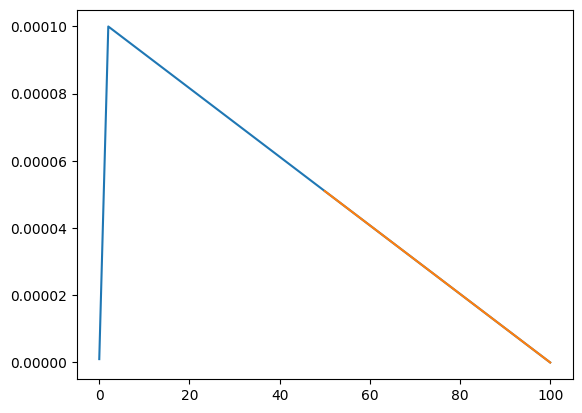

In [90]:
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import Adam


class WarmupLinearLRSchedule:
    """
    Implements Warmup learning rate schedule until 'warmup_steps', going from 'init_lr' to 'peak_lr' for multiple optimizers.
    """
    def __init__(self, optimizer, init_lr, peak_lr, end_lr, warmup_epochs, epochs=100, current_step=0):
        self.init_lr = init_lr
        self.peak_lr = peak_lr
        self.optimizer = optimizer
        self.warmup_rate = (peak_lr - init_lr) / warmup_epochs
        self.decay_rate = (end_lr - peak_lr) / (epochs - warmup_epochs)
        self.update_steps = current_step
        self.lr = init_lr
        self.warmup_steps = warmup_epochs
        self.epochs = epochs
        if current_step > 0:
            self.lr = self.peak_lr + self.decay_rate * (current_step - 1 - warmup_epochs)

    def set_lr(self, lr):
        # print(f"Setting lr: {lr}")
        for g in self.optimizer.param_groups:
            g['lr'] = lr

    def step(self):
        if self.update_steps <= self.warmup_steps:
            lr = self.init_lr + self.warmup_rate * self.update_steps
        # elif self.warmup_steps < self.update_steps <= self.epochs:
        else:
            lr = max(0., self.lr + self.decay_rate)
        self.set_lr(lr)
        self.lr = lr
        self.update_steps += 1
        return self.lr


if __name__ == '__main__':
    m = nn.Linear(10, 10)
    opt = Adam(m.parameters(), lr=1e-4)
    s = WarmupLinearLRSchedule(opt, 1e-6, 1e-4, 0., 2)
    lrs = []
    for i in range(101):
        s.step()
        lrs.append(s.lr)
        print(s.lr)

    m = nn.Linear(10, 10)
    opt = Adam(m.parameters(), lr=1e-4)
    s = WarmupLinearLRSchedule(opt, 1e-6, 1e-4, 0., 2, current_step=50)
    lrs_s = []
    for i in range(50, 101):
        s.step()
        lrs_s.append(s.lr)
        print(s.lr)

    plt.plot(lrs)
    plt.plot(range(50, 101), lrs_s)
    plt.show()

In [91]:
def plot_images(images: dict):
    x = images["input"]
    reconstruction = images["rec"]
    half_sample = images["half_sample"]
    new_sample = images["new_sample"]

    fig, axarr = plt.subplots(1, 4)
    axarr[0].imshow(x.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[1].imshow(reconstruction.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[2].imshow(half_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[3].imshow(new_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    plt.show()

In [92]:
import os
import numpy as np
from tqdm import tqdm
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import utils as vutils
from torch.utils.tensorboard import SummaryWriter


class TrainTransformer:
    def __init__(self, args):
        self.model = VQVAETransformer(args).to(device=args.device)
        self.lr = args.learning_rate
        self.optim = self.configure_optimizers()
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
              self.optim,
              T_max=500,
              eta_min=1e-6
        )

        """
        self.lr_schedule = WarmupLinearLRSchedule(
            optimizer=self.optim,
            init_lr=1e-6,
            peak_lr=args.learning_rate,
            end_lr=0.,
            warmup_epochs=0,
            epochs=args.epochs,
            current_step=0
        )
        """

        if args.start_from_epoch > 1:
            print(args.start_from_epoch)
            ckpt = torch.load(
            os.path.join("checkpoints", f"transformer_pokemon_epoch_{args.start_from_epoch}.pt"),
            map_location=args.device
            )
            self.model.transformer.load_state_dict(ckpt["model"])
            self.optim.load_state_dict(ckpt["optimizer"])
            self.global_step = ckpt["step"]
            print(f"Resumed training from epoch {ckpt['epoch']}")
        if args.start_from_epoch > 0:
            self.lr = args.learning_rate
        if args.run_name:
            self.logger = SummaryWriter(f"./runs/{args.run_name}")
        else:
            self.logger = SummaryWriter()
        self.train(args)

    def save_checkpoint(self, epoch, step):
      os.makedirs("checkpoints", exist_ok=True)
      if epoch > 1:
        os.remove(f"checkpoints/transformer_pokemon_epoch_{epoch-1}.pt")
      torch.save(
        {
            "epoch": epoch,
            "step": step,
            "model": self.model.transformer.state_dict(),
            "optimizer": self.optim.state_dict(),
        },
        os.path.join("checkpoints", f"transformer_pokemon_epoch_{epoch}.pt")
    )

    def validate(self, args):
      self.model.eval()
      total_loss = 0

      with torch.no_grad():
          for batch_data in validation_loader:
              _, imgs, _ = batch_data
              imgs = imgs.to(device=args.device)

              logits, target = self.model(imgs)

              loss = F.cross_entropy(
                  logits.reshape(-1, logits.size(-1)),
                  target.reshape(-1)
              )

              total_loss += loss.item()

      avg_loss = total_loss / len(validation_loader)
      return avg_loss


    def train(self, args):
        train_dataset = training_loader
        len_train_dataset = len(train_dataset)
        step = args.start_from_epoch * len_train_dataset
        for epoch in range(args.start_from_epoch+1, args.epochs+1):
            print(f"Epoch {epoch}:")
            total_train_loss = 0
            with tqdm(range(len(train_dataset))) as pbar:
                for i, batch_data in zip(pbar, train_dataset):
                    #self.lr_schedule.step()
                    _, imgs, _ = batch_data # Unpack the tuple: images and labels (labels are not used here)
                    imgs = imgs.to(device=args.device)
                    logits, target = self.model(imgs)
                    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
                    loss.backward()
                    if step % args.accum_grad == 0:
                        self.optim.step()
                        self.optim.zero_grad()
                    step += 1
                    total_train_loss += loss.item()
                    pbar.set_postfix(Transformer_Loss=np.round(loss.cpu().detach().numpy().item(), 4))
                    pbar.update(0)
                    self.logger.add_scalar("Cross Entropy Loss", np.round(loss.cpu().detach().numpy().item(), 4), (epoch * len_train_dataset) + i)
            avg_train_loss = total_train_loss / len(train_dataset)

            val_loss = self.validate(args)
            self.logger.add_scalar("Train Loss", avg_train_loss, epoch)
            self.logger.add_scalar("Val Loss", val_loss, epoch)
            self.scheduler.step()
            self.save_checkpoint(epoch, step)

            print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {val_loss:.4f} | LR: {self.optim.param_groups[0]['lr']:.4f}")
            print(f"Checkpoint saved at epoch {epoch}")


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.transformer.parameters(), lr=self.lr, betas=(0.9, 0.96), weight_decay=4.5e-2)
        return optimizer


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="VQGAN")
    parser.add_argument('--run-name', type=str, default=None)
    parser.add_argument('--latent-dim', type=int, default=1024, help='Latent dimension n_z.')
    parser.add_argument('--image-size', type=int, default=128, help='Image height and width.)')
    parser.add_argument('--num-codebook-vectors', type=int, default=64, help='Number of codebook vectors.')
    parser.add_argument('--beta', type=float, default=0.25, help='Commitment loss scalar.')
    parser.add_argument('--image-channels', type=int, default=3, help='Number of channels of images.')
    parser.add_argument('--dataset-path', type=str, default='./data', help='Path to data.')
    parser.add_argument('--checkpoint-path', type=str, default='./checkpoints/last_ckpt.pt', help='Path to checkpoint.')
    parser.add_argument('--device', type=str, default=device, help='Which device the training is on.')
    parser.add_argument('--batch-size', type=int, default=1, help='Batch size for training.')
    parser.add_argument('--accum-grad', type=int, default=10, help='Number for gradient accumulation.')
    parser.add_argument('--epochs', type=int, default=1000, help='Number of epochs to train.')
    parser.add_argument('--start-from-epoch', type=int, default=100, help='Number of epochs to train.')
    parser.add_argument('--ckpt-interval', type=int, default=100, help='Number of epochs to train.')
    parser.add_argument('--learning-rate', type=float, default=1e-4, help='Learning rate.')

    parser.add_argument('--sos-token', type=int, default=1025, help='Start of Sentence token.')

    parser.add_argument('--n-layers', type=int, default=24, help='Number of layers of transformer.')
    parser.add_argument('--dim', type=int, default=768, help='Dimension of transformer.')
    parser.add_argument('--hidden-dim', type=int, default=3072, help='Dimension of transformer.')
    parser.add_argument('--num-image-tokens', type=int, default=256, help='Number of image tokens.')

    args = parser.parse_args([]) # Modified this line
    args.run_name = "<name>"
    args.dataset_path = r"C:\Users\dome\datasets\landscape"
    args.checkpoint_path = r".\..\checkpoints"
    args.n_layers = 4
    args.dim = 128
    args.hidden_dim = 512
    args.batch_size = 1
    args.accum_grad = 10
    args.epochs = 100

    args.start_from_epoch = 0

    args.num_codebook_vectors = codebook_size
    args.num_image_tokens = num_tokens

In [59]:
train_transformer = TrainTransformer(args)

Initializing Module Embedding.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module Linear.
Transformer parameters: 958082
Epoch 1:


  0%|          | 0/182 [00:00<?, ?it/s]/Users/sayansuos/Library/CloudStorage/OneDrive-Personnel/Documents/ENSAI/3A/Projet de fin d'études/3A-pfe/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 182/182 [01:14<00:00,  2.44it/s, Transformer_Loss=3.44]


Train Loss: 4.0399 | Validation Loss: 3.4679 | LR: 0.0001
Checkpoint saved at epoch 1
Epoch 2:


100%|██████████| 182/182 [00:44<00:00,  4.09it/s, Transformer_Loss=3.28]


Train Loss: 3.2020 | Validation Loss: 3.0195 | LR: 0.0001
Checkpoint saved at epoch 2
Epoch 3:


100%|██████████| 182/182 [00:53<00:00,  3.43it/s, Transformer_Loss=2.51]


Train Loss: 2.8177 | Validation Loss: 2.7084 | LR: 0.0001
Checkpoint saved at epoch 3
Epoch 4:


100%|██████████| 182/182 [01:07<00:00,  2.68it/s, Transformer_Loss=2.76]


Train Loss: 2.5057 | Validation Loss: 2.4168 | LR: 0.0001
Checkpoint saved at epoch 4
Epoch 5:


100%|██████████| 182/182 [01:04<00:00,  2.83it/s, Transformer_Loss=2.05]


Train Loss: 2.2161 | Validation Loss: 2.0963 | LR: 0.0001
Checkpoint saved at epoch 5
Epoch 6:


100%|██████████| 182/182 [00:47<00:00,  3.84it/s, Transformer_Loss=1.78]


Train Loss: 1.9907 | Validation Loss: 1.9317 | LR: 0.0001
Checkpoint saved at epoch 6
Epoch 7:


100%|██████████| 182/182 [00:50<00:00,  3.59it/s, Transformer_Loss=1.93]


Train Loss: 1.8100 | Validation Loss: 1.6869 | LR: 0.0001
Checkpoint saved at epoch 7
Epoch 8:


100%|██████████| 182/182 [00:47<00:00,  3.85it/s, Transformer_Loss=1.4] 


Train Loss: 1.6506 | Validation Loss: 1.6151 | LR: 0.0001
Checkpoint saved at epoch 8
Epoch 9:


100%|██████████| 182/182 [00:47<00:00,  3.86it/s, Transformer_Loss=1.21] 


Train Loss: 1.4859 | Validation Loss: 1.6234 | LR: 0.0001
Checkpoint saved at epoch 9
Epoch 10:


100%|██████████| 182/182 [00:51<00:00,  3.52it/s, Transformer_Loss=0.989]


Train Loss: 1.3539 | Validation Loss: 1.2581 | LR: 0.0001
Checkpoint saved at epoch 10
Epoch 11:


100%|██████████| 182/182 [00:46<00:00,  3.88it/s, Transformer_Loss=0.977]


Train Loss: 1.2727 | Validation Loss: 1.2889 | LR: 0.0001
Checkpoint saved at epoch 11
Epoch 12:


100%|██████████| 182/182 [00:47<00:00,  3.85it/s, Transformer_Loss=1.07] 


Train Loss: 1.1778 | Validation Loss: 1.1511 | LR: 0.0001
Checkpoint saved at epoch 12
Epoch 13:


100%|██████████| 182/182 [00:51<00:00,  3.55it/s, Transformer_Loss=0.847]


Train Loss: 1.1198 | Validation Loss: 1.1977 | LR: 0.0001
Checkpoint saved at epoch 13
Epoch 14:


100%|██████████| 182/182 [00:47<00:00,  3.81it/s, Transformer_Loss=1.45] 


Train Loss: 1.0254 | Validation Loss: 1.0730 | LR: 0.0001
Checkpoint saved at epoch 14
Epoch 15:


100%|██████████| 182/182 [00:48<00:00,  3.76it/s, Transformer_Loss=0.919]


Train Loss: 0.9965 | Validation Loss: 0.9427 | LR: 0.0001
Checkpoint saved at epoch 15
Epoch 16:


100%|██████████| 182/182 [00:49<00:00,  3.71it/s, Transformer_Loss=0.785]


Train Loss: 0.9205 | Validation Loss: 0.9766 | LR: 0.0001
Checkpoint saved at epoch 16
Epoch 17:


100%|██████████| 182/182 [00:47<00:00,  3.82it/s, Transformer_Loss=0.948]


Train Loss: 0.9249 | Validation Loss: 0.8263 | LR: 0.0001
Checkpoint saved at epoch 17
Epoch 18:


100%|██████████| 182/182 [00:47<00:00,  3.80it/s, Transformer_Loss=0.819]


Train Loss: 0.8160 | Validation Loss: 0.8859 | LR: 0.0001
Checkpoint saved at epoch 18
Epoch 19:


100%|██████████| 182/182 [00:46<00:00,  3.90it/s, Transformer_Loss=0.402]


Train Loss: 0.7953 | Validation Loss: 0.7654 | LR: 0.0001
Checkpoint saved at epoch 19
Epoch 20:


100%|██████████| 182/182 [00:45<00:00,  4.03it/s, Transformer_Loss=0.384]


Train Loss: 0.7259 | Validation Loss: 0.8597 | LR: 0.0001
Checkpoint saved at epoch 20
Epoch 21:


100%|██████████| 182/182 [00:47<00:00,  3.82it/s, Transformer_Loss=0.501]


Train Loss: 0.7685 | Validation Loss: 0.8981 | LR: 0.0001
Checkpoint saved at epoch 21
Epoch 22:


100%|██████████| 182/182 [00:43<00:00,  4.15it/s, Transformer_Loss=0.802]


Train Loss: 0.6903 | Validation Loss: 0.8376 | LR: 0.0001
Checkpoint saved at epoch 22
Epoch 23:


100%|██████████| 182/182 [00:45<00:00,  3.96it/s, Transformer_Loss=0.414]


Train Loss: 0.7147 | Validation Loss: 0.6691 | LR: 0.0001
Checkpoint saved at epoch 23
Epoch 24:


100%|██████████| 182/182 [00:47<00:00,  3.86it/s, Transformer_Loss=0.354]


Train Loss: 0.6334 | Validation Loss: 0.7373 | LR: 0.0001
Checkpoint saved at epoch 24
Epoch 25:


100%|██████████| 182/182 [00:46<00:00,  3.93it/s, Transformer_Loss=0.889]


Train Loss: 0.6438 | Validation Loss: 0.6775 | LR: 0.0001
Checkpoint saved at epoch 25
Epoch 26:


100%|██████████| 182/182 [00:45<00:00,  4.00it/s, Transformer_Loss=0.678]


Train Loss: 0.6475 | Validation Loss: 0.8337 | LR: 0.0001
Checkpoint saved at epoch 26
Epoch 27:


100%|██████████| 182/182 [00:45<00:00,  4.04it/s, Transformer_Loss=1.34] 


Train Loss: 0.6645 | Validation Loss: 0.6750 | LR: 0.0001
Checkpoint saved at epoch 27
Epoch 28:


100%|██████████| 182/182 [00:46<00:00,  3.93it/s, Transformer_Loss=0.279]


Train Loss: 0.6877 | Validation Loss: 0.5984 | LR: 0.0001
Checkpoint saved at epoch 28
Epoch 29:


100%|██████████| 182/182 [00:46<00:00,  3.89it/s, Transformer_Loss=0.201]


Train Loss: 0.6085 | Validation Loss: 0.6685 | LR: 0.0001
Checkpoint saved at epoch 29
Epoch 30:


100%|██████████| 182/182 [00:46<00:00,  3.89it/s, Transformer_Loss=0.643]


Train Loss: 0.5864 | Validation Loss: 0.6168 | LR: 0.0001
Checkpoint saved at epoch 30
Epoch 31:


100%|██████████| 182/182 [00:44<00:00,  4.06it/s, Transformer_Loss=1.14] 


Train Loss: 0.6057 | Validation Loss: 0.7023 | LR: 0.0001
Checkpoint saved at epoch 31
Epoch 32:


100%|██████████| 182/182 [00:46<00:00,  3.94it/s, Transformer_Loss=0.723] 


Train Loss: 0.5904 | Validation Loss: 0.5478 | LR: 0.0001
Checkpoint saved at epoch 32
Epoch 33:


100%|██████████| 182/182 [00:47<00:00,  3.84it/s, Transformer_Loss=0.844] 


Train Loss: 0.5340 | Validation Loss: 0.6789 | LR: 0.0001
Checkpoint saved at epoch 33
Epoch 34:


100%|██████████| 182/182 [00:46<00:00,  3.95it/s, Transformer_Loss=0.61]  


Train Loss: 0.5882 | Validation Loss: 0.9332 | LR: 0.0001
Checkpoint saved at epoch 34
Epoch 35:


100%|██████████| 182/182 [00:45<00:00,  4.01it/s, Transformer_Loss=0.239] 


Train Loss: 0.5561 | Validation Loss: 0.4037 | LR: 0.0001
Checkpoint saved at epoch 35
Epoch 36:


100%|██████████| 182/182 [00:46<00:00,  3.88it/s, Transformer_Loss=1.37]  


Train Loss: 0.6016 | Validation Loss: 0.6348 | LR: 0.0001
Checkpoint saved at epoch 36
Epoch 37:


100%|██████████| 182/182 [00:46<00:00,  3.93it/s, Transformer_Loss=0.0779]


Train Loss: 0.6225 | Validation Loss: 0.6593 | LR: 0.0001
Checkpoint saved at epoch 37
Epoch 38:


100%|██████████| 182/182 [00:45<00:00,  3.99it/s, Transformer_Loss=0.706] 


Train Loss: 0.5282 | Validation Loss: 0.5189 | LR: 0.0001
Checkpoint saved at epoch 38
Epoch 39:


100%|██████████| 182/182 [00:44<00:00,  4.07it/s, Transformer_Loss=0.443] 


Train Loss: 0.5561 | Validation Loss: 0.7188 | LR: 0.0001
Checkpoint saved at epoch 39
Epoch 40:


100%|██████████| 182/182 [00:46<00:00,  3.95it/s, Transformer_Loss=0.608] 


Train Loss: 0.5254 | Validation Loss: 0.6258 | LR: 0.0001
Checkpoint saved at epoch 40
Epoch 41:


100%|██████████| 182/182 [00:47<00:00,  3.81it/s, Transformer_Loss=1.6]   


Train Loss: 0.5445 | Validation Loss: 0.4498 | LR: 0.0001
Checkpoint saved at epoch 41
Epoch 42:


100%|██████████| 182/182 [00:49<00:00,  3.66it/s, Transformer_Loss=0.68]  


Train Loss: 0.5743 | Validation Loss: 0.4660 | LR: 0.0001
Checkpoint saved at epoch 42
Epoch 43:


100%|██████████| 182/182 [00:49<00:00,  3.69it/s, Transformer_Loss=0.0988]


Train Loss: 0.5642 | Validation Loss: 0.7011 | LR: 0.0001
Checkpoint saved at epoch 43
Epoch 44:


100%|██████████| 182/182 [00:44<00:00,  4.07it/s, Transformer_Loss=1.12]  


Train Loss: 0.5390 | Validation Loss: 0.5506 | LR: 0.0001
Checkpoint saved at epoch 44
Epoch 45:


100%|██████████| 182/182 [00:43<00:00,  4.17it/s, Transformer_Loss=0.288] 


Train Loss: 0.5500 | Validation Loss: 0.4463 | LR: 0.0001
Checkpoint saved at epoch 45
Epoch 46:


100%|██████████| 182/182 [00:43<00:00,  4.16it/s, Transformer_Loss=1.18]  


Train Loss: 0.5792 | Validation Loss: 0.6310 | LR: 0.0001
Checkpoint saved at epoch 46
Epoch 47:


100%|██████████| 182/182 [00:43<00:00,  4.20it/s, Transformer_Loss=0.326] 


Train Loss: 0.4852 | Validation Loss: 0.6328 | LR: 0.0001
Checkpoint saved at epoch 47
Epoch 48:


100%|██████████| 182/182 [00:45<00:00,  4.00it/s, Transformer_Loss=0.596] 


Train Loss: 0.5431 | Validation Loss: 0.6212 | LR: 0.0001
Checkpoint saved at epoch 48
Epoch 49:


100%|██████████| 182/182 [00:46<00:00,  3.91it/s, Transformer_Loss=1.61]  


Train Loss: 0.6463 | Validation Loss: 0.4774 | LR: 0.0001
Checkpoint saved at epoch 49
Epoch 50:


100%|██████████| 182/182 [00:46<00:00,  3.95it/s, Transformer_Loss=0.227] 


Train Loss: 0.5564 | Validation Loss: 0.6401 | LR: 0.0001
Checkpoint saved at epoch 50
Epoch 51:


100%|██████████| 182/182 [00:46<00:00,  3.88it/s, Transformer_Loss=1.35]  


Train Loss: 0.5349 | Validation Loss: 0.5439 | LR: 0.0001
Checkpoint saved at epoch 51
Epoch 52:


100%|██████████| 182/182 [00:50<00:00,  3.64it/s, Transformer_Loss=0.0649]


Train Loss: 0.5250 | Validation Loss: 0.5747 | LR: 0.0001
Checkpoint saved at epoch 52
Epoch 53:


100%|██████████| 182/182 [00:47<00:00,  3.83it/s, Transformer_Loss=0.172] 


Train Loss: 0.5004 | Validation Loss: 0.4906 | LR: 0.0001
Checkpoint saved at epoch 53
Epoch 54:


100%|██████████| 182/182 [00:47<00:00,  3.86it/s, Transformer_Loss=0.414] 


Train Loss: 0.5205 | Validation Loss: 0.5850 | LR: 0.0001
Checkpoint saved at epoch 54
Epoch 55:


100%|██████████| 182/182 [00:46<00:00,  3.88it/s, Transformer_Loss=0.763] 


Train Loss: 0.5547 | Validation Loss: 0.5846 | LR: 0.0001
Checkpoint saved at epoch 55
Epoch 56:


100%|██████████| 182/182 [00:45<00:00,  3.97it/s, Transformer_Loss=0.233] 


Train Loss: 0.5791 | Validation Loss: 0.5741 | LR: 0.0001
Checkpoint saved at epoch 56
Epoch 57:


100%|██████████| 182/182 [00:47<00:00,  3.87it/s, Transformer_Loss=0.609] 


Train Loss: 0.5114 | Validation Loss: 0.7385 | LR: 0.0001
Checkpoint saved at epoch 57
Epoch 58:


100%|██████████| 182/182 [00:49<00:00,  3.67it/s, Transformer_Loss=1.38]  


Train Loss: 0.4998 | Validation Loss: 0.5405 | LR: 0.0001
Checkpoint saved at epoch 58
Epoch 59:


100%|██████████| 182/182 [00:49<00:00,  3.70it/s, Transformer_Loss=0.422] 


Train Loss: 0.5430 | Validation Loss: 0.6135 | LR: 0.0001
Checkpoint saved at epoch 59
Epoch 60:


100%|██████████| 182/182 [00:46<00:00,  3.91it/s, Transformer_Loss=0.254] 


Train Loss: 0.5261 | Validation Loss: 0.4557 | LR: 0.0001
Checkpoint saved at epoch 60
Epoch 61:


100%|██████████| 182/182 [00:49<00:00,  3.67it/s, Transformer_Loss=0.0816]


Train Loss: 0.5317 | Validation Loss: 0.5759 | LR: 0.0001
Checkpoint saved at epoch 61
Epoch 62:


100%|██████████| 182/182 [00:47<00:00,  3.85it/s, Transformer_Loss=0.132] 


Train Loss: 0.5007 | Validation Loss: 0.6186 | LR: 0.0001
Checkpoint saved at epoch 62
Epoch 63:


100%|██████████| 182/182 [00:49<00:00,  3.64it/s, Transformer_Loss=0.304] 


Train Loss: 0.5261 | Validation Loss: 0.5983 | LR: 0.0001
Checkpoint saved at epoch 63
Epoch 64:


100%|██████████| 182/182 [00:48<00:00,  3.73it/s, Transformer_Loss=0.0694]


Train Loss: 0.5994 | Validation Loss: 0.5321 | LR: 0.0001
Checkpoint saved at epoch 64
Epoch 65:


100%|██████████| 182/182 [00:51<00:00,  3.56it/s, Transformer_Loss=0.352] 


Train Loss: 0.5172 | Validation Loss: 0.5101 | LR: 0.0001
Checkpoint saved at epoch 65
Epoch 66:


100%|██████████| 182/182 [00:48<00:00,  3.75it/s, Transformer_Loss=0.477] 


Train Loss: 0.5514 | Validation Loss: 0.4863 | LR: 0.0001
Checkpoint saved at epoch 66
Epoch 67:


100%|██████████| 182/182 [00:51<00:00,  3.56it/s, Transformer_Loss=0.101] 


Train Loss: 0.4999 | Validation Loss: 0.4651 | LR: 0.0001
Checkpoint saved at epoch 67
Epoch 68:


100%|██████████| 182/182 [00:54<00:00,  3.36it/s, Transformer_Loss=0.723] 


Train Loss: 0.5816 | Validation Loss: 0.6632 | LR: 0.0001
Checkpoint saved at epoch 68
Epoch 69:


100%|██████████| 182/182 [01:16<00:00,  2.39it/s, Transformer_Loss=0.296] 


Train Loss: 0.5393 | Validation Loss: 0.6709 | LR: 0.0001
Checkpoint saved at epoch 69
Epoch 70:


100%|██████████| 182/182 [01:02<00:00,  2.91it/s, Transformer_Loss=0.0471]


Train Loss: 0.5328 | Validation Loss: 0.5704 | LR: 0.0001
Checkpoint saved at epoch 70
Epoch 71:


100%|██████████| 182/182 [01:00<00:00,  3.00it/s, Transformer_Loss=1.91]  


Train Loss: 0.4986 | Validation Loss: 0.5750 | LR: 0.0001
Checkpoint saved at epoch 71
Epoch 72:


100%|██████████| 182/182 [00:56<00:00,  3.24it/s, Transformer_Loss=0.572] 


Train Loss: 0.4981 | Validation Loss: 0.6147 | LR: 0.0001
Checkpoint saved at epoch 72
Epoch 73:


100%|██████████| 182/182 [00:55<00:00,  3.27it/s, Transformer_Loss=0.0991]


Train Loss: 0.5246 | Validation Loss: 0.5418 | LR: 0.0001
Checkpoint saved at epoch 73
Epoch 74:


100%|██████████| 182/182 [01:01<00:00,  2.95it/s, Transformer_Loss=0.282] 


Train Loss: 0.5331 | Validation Loss: 0.6202 | LR: 0.0001
Checkpoint saved at epoch 74
Epoch 75:


100%|██████████| 182/182 [00:54<00:00,  3.36it/s, Transformer_Loss=0.533] 


Train Loss: 0.5825 | Validation Loss: 0.5947 | LR: 0.0001
Checkpoint saved at epoch 75
Epoch 76:


100%|██████████| 182/182 [00:52<00:00,  3.44it/s, Transformer_Loss=0.578] 


Train Loss: 0.5332 | Validation Loss: 0.3766 | LR: 0.0001
Checkpoint saved at epoch 76
Epoch 77:


100%|██████████| 182/182 [00:54<00:00,  3.33it/s, Transformer_Loss=0.0678]


Train Loss: 0.5522 | Validation Loss: 0.4774 | LR: 0.0001
Checkpoint saved at epoch 77
Epoch 78:


100%|██████████| 182/182 [00:53<00:00,  3.39it/s, Transformer_Loss=1.59]  


Train Loss: 0.5151 | Validation Loss: 0.2921 | LR: 0.0001
Checkpoint saved at epoch 78
Epoch 79:


100%|██████████| 182/182 [00:52<00:00,  3.45it/s, Transformer_Loss=0.168] 


Train Loss: 0.5066 | Validation Loss: 0.6216 | LR: 0.0001
Checkpoint saved at epoch 79
Epoch 80:


100%|██████████| 182/182 [00:53<00:00,  3.41it/s, Transformer_Loss=0.0522]


Train Loss: 0.5698 | Validation Loss: 0.7951 | LR: 0.0001
Checkpoint saved at epoch 80
Epoch 81:


100%|██████████| 182/182 [00:53<00:00,  3.38it/s, Transformer_Loss=0.122] 


Train Loss: 0.5459 | Validation Loss: 0.6004 | LR: 0.0001
Checkpoint saved at epoch 81
Epoch 82:


100%|██████████| 182/182 [00:53<00:00,  3.42it/s, Transformer_Loss=1.09]  


Train Loss: 0.5363 | Validation Loss: 0.6556 | LR: 0.0001
Checkpoint saved at epoch 82
Epoch 83:


100%|██████████| 182/182 [00:55<00:00,  3.31it/s, Transformer_Loss=0.099] 


Train Loss: 0.5281 | Validation Loss: 0.5281 | LR: 0.0001
Checkpoint saved at epoch 83
Epoch 84:


100%|██████████| 182/182 [00:54<00:00,  3.33it/s, Transformer_Loss=0.08]  


Train Loss: 0.5605 | Validation Loss: 0.4234 | LR: 0.0001
Checkpoint saved at epoch 84
Epoch 85:


100%|██████████| 182/182 [00:52<00:00,  3.48it/s, Transformer_Loss=0.103] 


Train Loss: 0.5326 | Validation Loss: 0.4478 | LR: 0.0001
Checkpoint saved at epoch 85
Epoch 86:


100%|██████████| 182/182 [00:50<00:00,  3.61it/s, Transformer_Loss=1.04]  


Train Loss: 0.5349 | Validation Loss: 0.6854 | LR: 0.0001
Checkpoint saved at epoch 86
Epoch 87:


100%|██████████| 182/182 [00:51<00:00,  3.50it/s, Transformer_Loss=0.0474]


Train Loss: 0.5458 | Validation Loss: 0.6592 | LR: 0.0001
Checkpoint saved at epoch 87
Epoch 88:


100%|██████████| 182/182 [00:48<00:00,  3.78it/s, Transformer_Loss=0.279] 


Train Loss: 0.5628 | Validation Loss: 0.7791 | LR: 0.0001
Checkpoint saved at epoch 88
Epoch 89:


100%|██████████| 182/182 [00:50<00:00,  3.57it/s, Transformer_Loss=0.236] 


Train Loss: 0.5697 | Validation Loss: 0.4939 | LR: 0.0001
Checkpoint saved at epoch 89
Epoch 90:


100%|██████████| 182/182 [00:51<00:00,  3.54it/s, Transformer_Loss=0.64]  


Train Loss: 0.5343 | Validation Loss: 0.6126 | LR: 0.0001
Checkpoint saved at epoch 90
Epoch 91:


100%|██████████| 182/182 [00:49<00:00,  3.69it/s, Transformer_Loss=1.18]  


Train Loss: 0.5511 | Validation Loss: 0.4972 | LR: 0.0001
Checkpoint saved at epoch 91
Epoch 92:


100%|██████████| 182/182 [00:48<00:00,  3.76it/s, Transformer_Loss=0.105] 


Train Loss: 0.5438 | Validation Loss: 0.4103 | LR: 0.0001
Checkpoint saved at epoch 92
Epoch 93:


100%|██████████| 182/182 [00:49<00:00,  3.69it/s, Transformer_Loss=0.233] 


Train Loss: 0.5790 | Validation Loss: 0.5236 | LR: 0.0001
Checkpoint saved at epoch 93
Epoch 94:


100%|██████████| 182/182 [00:47<00:00,  3.83it/s, Transformer_Loss=0.128] 


Train Loss: 0.5515 | Validation Loss: 0.6867 | LR: 0.0001
Checkpoint saved at epoch 94
Epoch 95:


100%|██████████| 182/182 [00:47<00:00,  3.82it/s, Transformer_Loss=0.467] 


Train Loss: 0.5678 | Validation Loss: 0.7939 | LR: 0.0001
Checkpoint saved at epoch 95
Epoch 96:


100%|██████████| 182/182 [00:47<00:00,  3.82it/s, Transformer_Loss=0.783] 


Train Loss: 0.5413 | Validation Loss: 0.6191 | LR: 0.0001
Checkpoint saved at epoch 96
Epoch 97:


100%|██████████| 182/182 [00:47<00:00,  3.82it/s, Transformer_Loss=0.0687]


Train Loss: 0.5191 | Validation Loss: 0.6605 | LR: 0.0001
Checkpoint saved at epoch 97
Epoch 98:


100%|██████████| 182/182 [00:47<00:00,  3.86it/s, Transformer_Loss=0.591] 


Train Loss: 0.5705 | Validation Loss: 0.6978 | LR: 0.0001
Checkpoint saved at epoch 98
Epoch 99:


100%|██████████| 182/182 [00:46<00:00,  3.89it/s, Transformer_Loss=0.139] 


Train Loss: 0.5201 | Validation Loss: 0.8022 | LR: 0.0001
Checkpoint saved at epoch 99
Epoch 100:


100%|██████████| 182/182 [00:49<00:00,  3.69it/s, Transformer_Loss=0.806] 


Train Loss: 0.5515 | Validation Loss: 0.4426 | LR: 0.0001
Checkpoint saved at epoch 100


In [95]:
vq_transformer = VQVAETransformer(args).to(args.device)
vq_transformer.load_transformer_checkpoint(epoch=100, device=device)

Initializing Module Embedding.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module Linear.
Transformer parameters: 958082
✅ Transformer chargé | epoch=100 | step=18200


In [96]:
# row_settings=["depth", "var_names"] permet de voir le nom de tes variables
summary(vq_transformer, row_settings=["depth", "var_names"])

Layer (type (var_name):depth-idx)                                           Param #
VQVAETransformer (VQVAETransformer)                                         --
├─BidirectionalTransformer (transformer): 1-1                               131,330
│    └─Embedding (tok_emb): 2-1                                             16,640
│    └─Sequential (blocks): 2-2                                             --
│    │    └─Encoder (0): 3-1                                                198,272
│    │    └─Encoder (1): 3-2                                                198,272
│    │    └─Encoder (2): 3-3                                                198,272
│    │    └─Encoder (3): 3-4                                                198,272
│    └─Sequential (Token_Prediction): 2-3                                   --
│    │    └─Linear (0): 3-5                                                 16,512
│    │    └─GELU (1): 3-6                                                   --
│    │    └─La

In [97]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    # Ensure the tensor is on CPU and detached from the computation graph
    # before converting to numpy
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))
    inp = inp + 0.5 # Add this line to shift values to [0,1] range
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

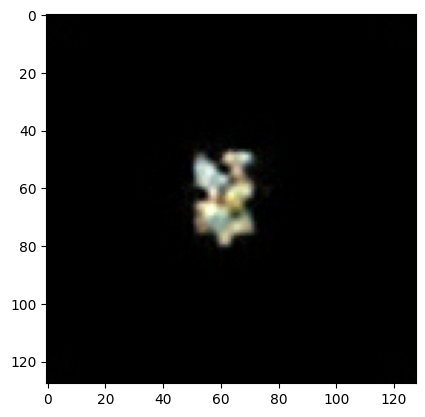

In [98]:
sampled_indices = vq_transformer.sample_good(T=100)
sampled_image = vq_transformer.indices_to_image(sampled_indices)
# Display the first image from the batch of sampled images
imshow(sampled_image[0].to("cpu").detach())

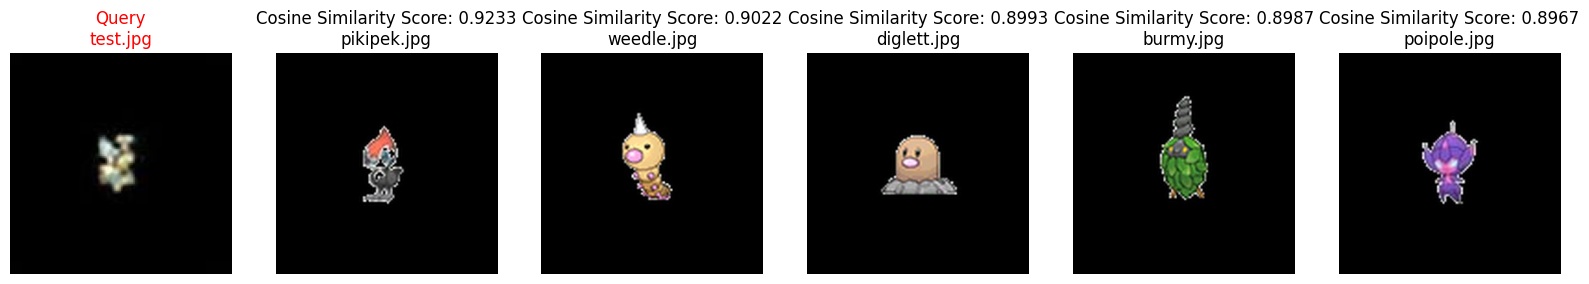

VQVAE output 100 -> Nearest neighbor: data/pokemon_images_256/pikipek.jpg


In [104]:
import torchvision.utils as vutils
from knn_images import *

database_folder = "data/pokemon_images_256"

path = f"test.jpg"
vutils.save_image(sampled_image + 0.5, path)
s, p = get_nearest_img(path, database_folder, model, device, k=5)
print(f"VQVAE output {i} -> Nearest neighbor: {p[0]}")
os.remove(path)

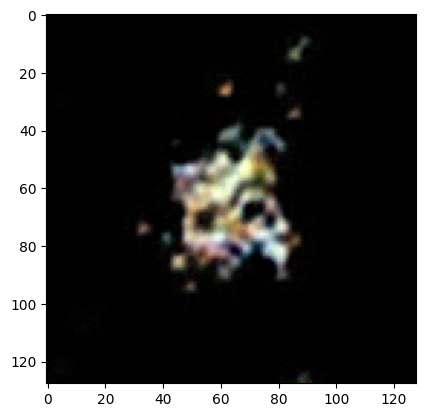

In [100]:
sampled_indices_gibbs = vq_transformer.sample_goods_gibbs()
sampled_image_gibbs = vq_transformer.indices_to_image(sampled_indices_gibbs)
# Display the first image from the batch of sampled images
imshow(sampled_image_gibbs[0].to("cpu").detach())

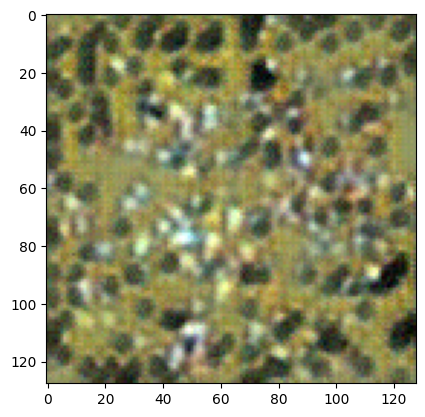

In [101]:
sampled_indices_mh = vq_transformer.sample_metropolis_hastings()
sampled_image_mh = vq_transformer.indices_to_image(sampled_indices_mh)
# Display the first image from the batch of sampled images
imshow(sampled_image_mh[0].to("cpu").detach())

In [105]:
import numpy as np

x = next(iter(validation_loader))[1]
x = x.to(args.device)

with torch.no_grad():
    _, z_indices = vq_transformer.encode_to_z(x)

image_idx = 0
original_image = x[image_idx]
original_indices = z_indices[image_idx].unsqueeze(0)

/Users/sayansuos/Library/CloudStorage/OneDrive-Personnel/Documents/ENSAI/3A/Projet de fin d'études/3A-pfe/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


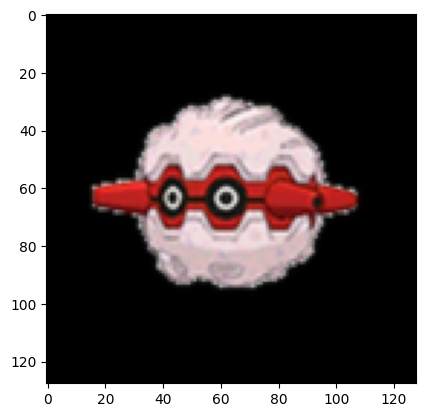

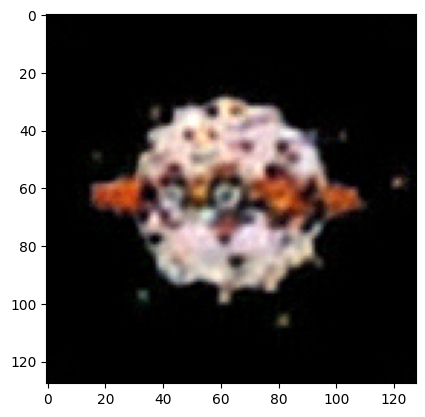

In [135]:
inpainted_indices = vq_transformer.sample_good(inputs=original_indices, T=1, masked_ratio=0.2)

inpainted_image = vq_transformer.indices_to_image(inpainted_indices)

imshow(original_image, title="Original Image")
imshow(inpainted_image[0], title="Inpainted Image")